# Philadelphia Crime Data Project
#### William McKee
#### October 2017

In this investigation, I am analyzing Philadelphia Crime Statistics from 2006 through 2015.  The data set is available on Kaggle.  I would like to know the following about crime in my home city:

(1) What parts of the city have the most crime?

(2) What crimes are most frequently committed?

(3) Has crime improved over time?

I will look at combinations to see how crime varies geographically in Philadelphia.  Are there parts of the city where the most common crimes take place?  Which areas have more violent crimes such as murder, rapes, and aggravated assaults?  Are there areas that are getting safer or less safe?

## Data Set Basic Statistics

The investigation begins by gathering basic data about Philadelphia crime statistics.  Below, we can see the number of entries in the data set, which is slightly above 2.2 million.

In [38]:
# Initial library declarations
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Store Philadelphia's crime data
crime_data = pd.read_csv('crime.csv')

# How large is data set?
print("Data dimensions: ")
print(crime_data.shape)

Data dimensions: 
(2237605, 14)


Here, we are able to see the names of our 14 columns, and get some basic information about them.

In [39]:
# Explore column names, max values, and min values
print("Column values:")
print(crime_data.columns.values)
print("\n")

print("Column max:")
print(crime_data.max())
print("\n")

print("Column min:")
print(crime_data.min())

Column values:
['Dc_Dist' 'Psa' 'Dispatch_Date_Time' 'Dispatch_Date' 'Dispatch_Time'
 'Hour' 'Dc_Key' 'Location_Block' 'UCR_General' 'Text_General_Code'
 'Police_Districts' 'Month' 'Lon' 'Lat']


Column max:
Dc_Dist                                92
Psa                                     Z
Dispatch_Date_Time    2017-03-23 01:29:00
Dispatch_Date                  2017-03-23
Dispatch_Time                    23:59:00
Hour                                   23
Dc_Key                       201777001445
Location_Block              `732 SIGEL ST
UCR_General                          2600
Police_Districts                       22
Month                             2017-03
Lon                              -74.9575
Lat                               40.1379
dtype: object


Column min:
Dc_Dist                                       1
Psa                                           1
Dispatch_Date_Time          2006-01-01 00:00:00
Dispatch_Date                        2006-01-01
Dispatch_Time             

Here, some data columns are explored, such as police districts, crime codes, and crime descriptions.

In [40]:
# Look at some distinct data
dc_dist_distinct = crime_data.groupby('Dc_Dist')['Dc_Dist'].count()
print(dc_dist_distinct)
print("\n")

ucr_text_distinct = crime_data.groupby(['UCR_General', 'Text_General_Code']).size()
print(ucr_text_distinct)

Dc_Dist
1      48815
2     116500
3      85816
4      29198
5      31433
6      96568
7      44687
8      73820
9      84046
12    132145
14    120931
15    184677
16     73052
17     74900
18    109746
19    138987
22    127332
23     27278
24    161909
25    151245
26     86982
35    131037
39     97061
77      7813
92      1627
Name: Dc_Dist, dtype: int64


UCR_General  Text_General_Code                      
100.0        Homicide - Criminal                          3442
             Homicide - Gross Negligence                    12
             Homicide - Justifiable                         42
200.0        Rape                                        11852
300.0        Robbery Firearm                             40577
             Robbery No Firearm                          51919
400.0        Aggravated Assault Firearm                  27934
             Aggravated Assault No Firearm               68989
500.0        Burglary Non-Residential                    23276
             Burg

Finally, I seen that the date and time entries generally had certain patterns.  This code will tell us if there is any data that does not have the correct pattern which would need cleaning.  Good news - there are no incorrectly formatted date and time entries.

In [41]:
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

# Check dates and times for consistent formatting
def does_column_match_pattern(data_frame, column_name, pattern):
    ''' Returns true if every value of a data frame column matches a pattern
        data_frame = the pandas data frame to be checked
        column_name = name of column to be checked
        pattern = regular expression to be matched
    '''
    data = data_frame[column_name]
    return data.str.contains(pattern).all()

# Patterns copied from http://regexlib.com/DisplayPatterns.aspx?cattabindex=4&categoryId=5&AspxAutoDetectCookieSupport=1
date_time_re = '20\d{2}-((0[1-9])|(1[0-2]))-((0[1-9])|([1-2][0-9])|(3[0-1]))(\s)(([0-1][0-9])|(2[0-3])):([0-5][0-9]):([0-5][0-9])'
date_re = '20\d{2}-((0[1-9])|(1[0-2]))-((0[1-9])|([1-2][0-9])|(3[0-1]))'
time_re = '^(([0-1]?[0-9])|([2][0-3])):([0-5]?[0-9])(:([0-5]?[0-9]))?$'
print("Do all elements in columns match expected pattern?")
print("Dispatch_Date_Time: ", does_column_match_pattern(crime_data, 'Dispatch_Date_Time', date_time_re))
print("Dispatch_Date: ", does_column_match_pattern(crime_data, 'Dispatch_Date', date_re))
print("Dispatch_Time: ", does_column_match_pattern(crime_data, 'Dispatch_Time', time_re))
print("Hour: ", ((crime_data['Hour'] >= 0) & (crime_data['Hour'] <= 23)).all())
print("Month: ", does_column_match_pattern(crime_data, 'Month', '[0-9]{4}-[0-9]{2}'))

Do all elements in columns match expected pattern?
Dispatch_Date_Time:  True
Dispatch_Date:  True
Dispatch_Time:  True
Hour:  True
Month:  True


## Data Set Cleaning

The Philadelphia Crime Data set contains over 2.2 million rows where each row represents one 911 call about a criminal incident in the city.  Each row includes information about the date, time, police district, street, and type of incident.  There are some 2016 and 2017 incidents in the data set but there are considerable gaps in the data for those two years.  There are no apparent gaps for 2006 through 2015 so I will include only those years in the investigation.  Following this cleaning step, the data set now contains slightly over two million rows.

In [42]:
# Remove incidents from 2016 and 2017 since there are large gaps in the data
years_included = ['2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015']
crime_data = crime_data[crime_data['Dispatch_Date_Time'].astype(str).str.startswith(tuple(years_included))]

# How large is data set now?
print("Data dimensions: ")
print(crime_data.shape)

Data dimensions: 
(2035062, 14)


There are less than 1000 entries which do not contain a crime classification and corresponding description.  Since I wish to measure the crime type, I will remove these rows from the data set.

In [43]:
# Exclude rows without a crime type or description
crime_data.dropna(subset=['UCR_General', 'Text_General_Code'], inplace = True)

# How large is data set now?
print("Data dimensions: ")
print(crime_data.shape)

Data dimensions: 
(2035062, 14)


When I looked at the distinct police districts represented in the dataset, I compared the district numbers to a map of the Philadelphia Police Districts.  There are four districts which no longer exist due to mergers.  The 4th district was merged into the 3rd district.  The 23rd was absored by the 22nd district.  The 77th was absorbed by the 12th district.  Meanwhile, the 92nd district is now part of the 14th district.  The same merger will occur in my data frame.

In [44]:
# Check before merger
print("Before district merger:")
dc_dist_distinct = crime_data.groupby('Dc_Dist')['Dc_Dist'].count()
print(dc_dist_distinct)
print("\n")

# Merge districts
crime_data.loc[crime_data.Dc_Dist == 4, 'Dc_Dist'] = 3
crime_data.loc[crime_data.Dc_Dist == 23, 'Dc_Dist'] = 22
crime_data.loc[crime_data.Dc_Dist == 77, 'Dc_Dist'] = 12
crime_data.loc[crime_data.Dc_Dist == 92, 'Dc_Dist'] = 14

# Check the result of the merger
print("After district merger:")
dc_dist_distinct = crime_data.groupby('Dc_Dist')['Dc_Dist'].count()
print(dc_dist_distinct)
print("\n")

Before district merger:
Dc_Dist
1      44775
2     106155
3      76989
4      29197
5      28582
6      87384
7      40653
8      67759
9      76028
12    121702
14    109950
15    167387
16     66705
17     69817
18     99031
19    124281
22    113371
23     27278
24    146134
25    138099
26     78988
35    119559
39     86675
77      6936
92      1627
Name: Dc_Dist, dtype: int64


After district merger:
Dc_Dist
1      44775
2     106155
3     106186
5      28582
6      87384
7      40653
8      67759
9      76028
12    128638
14    111577
15    167387
16     66705
17     69817
18     99031
19    124281
22    140649
24    146134
25    138099
26     78988
35    119559
39     86675
Name: Dc_Dist, dtype: int64




The **Location_Block** field is not consistent so there will be some cleaning needed to ensure the same pattern in the data.  The cleanup code will ensure that the locations are specified as either a block or an intersection.  A block is denoted as _2400 BLOCK FRONT STREET_.  An intersection fits the pattern _RHAWN ST / COTTMAN AV_.  The street types are standarized to ensure consistency as much as practical.  For example, all _ROAD_ street types are changed to _RD_.  Rows with empty or invalid locations (such as a single word) are removed from the data set.

In [45]:
import re

# Regular expressions
block_re = '^(\d+)(\s)BLOCK(\s)(.+)(\s)(\w+)$'
block_missed_re = '^(\d+)(\s)(.+)(\s)(\w+)$'
block_street_missed_re = '^(\d+)(.+)$'
street_missed_re = '^(\d+)(\s)BLOCK(\s)(.+)$'
int_amp_re = '^(.+)(\s)(\w+)(\s)&(.+)(\s)(\w+)$'
int_slash_re = '^(.+)(\s)(\w+)(\s)(\/)(.+)(\s)(\w+)$'

# Location formatting function
def format_location_data(item):
    ''' Format data set's location block column (invoked via apply method)
        item = one item from location block column
    '''  
    # Initial trimming
    item = item.strip()
    
    # Remove extraneous first characters
    if (item[0] == '`' or item[0] == '/'):
        item = item[1:]
        
    # Remove item with no whitespace
    if (len(item.split()) == 1):
        item = 'None'
    
    # We will not look at establishment, only the street
    if ('@' in item):
        at_index = item.index('@')
        item = item[at_index+1:] # also remove '@'
        item = item.strip()

    # BLOCK and SLASH patterns accepted at this stage
    if (re.fullmatch(block_re, item) or re.fullmatch(int_slash_re, item)):
        pass
    
    elif (re.fullmatch(street_missed_re, item)):
        # Add default street type
        item += " ST"
    
    elif (re.fullmatch(block_missed_re, item)):
        # Add BLOCK after number
        tokens = item.split()
        item = tokens[0] + " BLOCK"
        
        # Reconstruct string
        for i in range(1,len(tokens)):
            item = item + " " + tokens[i]
    
    elif (re.fullmatch(block_street_missed_re, item)):
        # Add BLOCK after number
        tokens = item.split()
        item = tokens[0] + " BLOCK"
        
        # Reconstruct string
        for i in range(1,len(tokens)):
            item = item + " " + tokens[i]
            
        # Add default street type
        item += " ST"
    
    elif (re.fullmatch(int_amp_re, item)):
        # Replace ampersand
        item = item.replace("&", "/")
    
    return item

# Street Types
STREET_TYPE_EXPECTED = ["AV", "BLVD", "CIR", "CT", "DR", "LN", "PKWY", "PL", "RD", "ROW", "ST", "TER", "WAY"]

STREET_TYPE_MAPPING = { "AVE": "AV",
                        "AVENUE": "AV",
                        "AVE": "AV",
                        "BLD": "BLVD",
                        "BLV": "BLVD",
                        "BDV": "BLVD",
                        "BOULEVARD": "BLVD",
                        "CI": "CIR",
                        "CIRCLE": "CIR",
                        "CRT": "CT",
                        "COURT": "CT",
                        "DRIVE": "DR",
                        "LANE": "LN",
                        "PKY": "PKWY",
                        "PWY": "PKWY",
                        "PARKWAY": "PKWY",
                        "PLA": "PL",
                        "PLACE": "PL",
                        "RDS": "RD",
                        "ROAD": "RD",
                        "STR": "ST",
                        "STT": "ST",
                        "STREET": "ST",
                        "TRCE": "TER",
                        "WA": "WAY"
                      }

# Street Type Formatting function
def format_street_type(item):
    ''' Format street type in data set's location block column (invoked via apply method)
        This function is invoked agter format_location_data
        item = one item from location block column
    '''
    # BLOCK pattern
    if (re.fullmatch(block_re, item)):
        tokens = item.split()
    
        # Check the hundred block
        if (tokens[0].isdigit()):
            # Check the hundred block
            tokens = item.split()
            block_num = int(tokens[0])
            block_num = (block_num // 100) * 100
            item = str(block_num)
        else:
            item = tokens[0]
            
        # Keep BLOCK and name of street
        item = item + " " + tokens[1] + " " + tokens[2]
    
        # Check remaining tokens for street type
        for i in range(3, len(tokens)):
            if (tokens[i] in STREET_TYPE_MAPPING):
                item = item + " " + STREET_TYPE_MAPPING[tokens[i]]
                break
            elif (tokens[i] in STREET_TYPE_EXPECTED):
                item = item + " " + tokens[i]
                break
            else:
                item = item + " " + tokens[i]
    
    # SLASH pattern
    elif (re.fullmatch(int_slash_re, item)):
        street_names = item.split('/')
        
        # Go through each part
        this_part = ""
        for i in range(0, len(street_names)):
            if (i>0):
                # Previous part
                item = this_part + " / "
                this_part = ""
                
            # Initial trimming
            street_names[i].strip()
            
            # Split this part
            tokens = street_names[i].split()
            
            # Empty item?
            if (len(tokens) == 0):
                break
        
            # Keep first token (for case like STREET RD)
            this_part = this_part + tokens[0]
            
            # Check remaining tokens for street type
            for j in range(1, len(tokens)):
                if (tokens[j] in STREET_TYPE_MAPPING):
                    this_part = this_part + " " + STREET_TYPE_MAPPING[tokens[j]]
                    break
                elif (tokens[j] in STREET_TYPE_EXPECTED):
                    this_part = this_part + " " + tokens[j]
                    break
                else:
                    this_part = this_part + " " + tokens[j]
            
        # Last part
        item = item + this_part

    return item

# Standardize the location data
crime_data['Location_Block'] = crime_data['Location_Block'].apply(format_location_data)

# Dump items with no information
crime_data = crime_data[crime_data['Location_Block'] != 'None']

# Standardize street type
crime_data['Location_Block'] = crime_data['Location_Block'].apply(format_street_type)

# How large is data set now?
print("Data dimensions: ")
print(crime_data.shape)

Data dimensions: 
(2034110, 14)


The next cleaning step involves the 911 calls. If multiple people placed a 911 call for the same incident, the incident is recorded twice in this data set.  These rows must be combined so that each incident is counted only once regardless of the number of 911 callers.  After removing such duplicates, the number of rows in the data set is about 1.95 million, or 80000 fewer than the previous iteration.

In [46]:
# Try groupby to remove duplicates
crime_data = crime_data.drop_duplicates(['Dispatch_Date_Time', 'Location_Block', 'UCR_General', 'Text_General_Code'])

# How large is data set now?
print("Data dimensions: ")
print(crime_data.shape)

Data dimensions: 
(1953458, 14)


Here, the 'Month' field, indicated by 'Year-Month' is broken into two fields for easier analysis in the next part.

In [47]:
def get_year(year_month_item):
    ''' Apply function to add only the year as a field in the data set'''
    return year_month_item[:4]

def get_month(year_month_item):
    ''' Apply function to add only the month as a field in the data set'''
    return year_month_item[5:]

# See if we can get year, month as separate fields in dataset - easier to plot these!
crime_data['Year'] = crime_data['Month'].apply(get_year)
crime_data['Actual_Month'] = crime_data['Month'].apply(get_month)

Finally, I am replacing the **UCR_General** column values with more meaningful values.

In [48]:
crime_type_dict = {100.0: 'Homicide',
                   200.0: 'Rape',
                   300.0: 'Robbery',
                   400.0: 'Aggravated Assault',
                   500.0: 'Burglary',
                   600.0: 'Theft',
                   700.0: 'Motor Vehicle Theft',
                   800.0: 'Other Assaults',
                   900.0: 'Arson',
                   1000.0: 'Forgery and Counterfeiting',
                   1100.0: 'Fraud',
                   1200.0: 'Embezzlement',
                   1300.0: 'Receiving Stolen Property',
                   1400.0: 'Vandalism',
                   1500.0: 'Weapon Violations',
                   1600.0: 'Prostitution',
                   1700.0: 'Other Sex Offenses',
                   1800.0: 'Drug Violations',
                   1900.0: 'Gambling Violations',
                   2000.0: 'Offenses against Families',
                   2100.0: 'Driving Under the Influence',
                   2200.0: 'Liquor Law Violations',
                   2300.0: 'Public Drunkenness',
                   2400.0: 'Disorderly Conduct',
                   2500.0: 'Vagrancy/Loitering',
                   2600.0: 'All Other Offenses'}

def replace_crime_type(ucr_general):
    '''Replace UCR General code with crime type'''
    if (ucr_general in crime_type_dict):
        ucr_general = crime_type_dict[ucr_general]
    return ucr_general

crime_data['UCR_General'] = crime_data['UCR_General'].apply(replace_crime_type)

## Univariate Data Analysis

Univariant analysis is shown below for crime type, police district, year, month, and hour.

The five worst police districts are the 12th, 15th, 22nd, 24th, and 25th.  The 12th district is in southwestern Philadelphia; the 15th is in the lower Northeast.  The 22nd, 24th, and 25th are located in the infamous "North Philadelphia" area, which has been crime ridden for decades.  The sixth to tenth worst districts include three near the Olney section of the city (2nd, 14th, and 35th districts).  South Philadelphia (3rd) and West Philadelphia (19th) round out the top ten.  The districts with the fewest incidents are the 1st (near the stadiums and the Naval Yard), 5th (Far Northwest), and 7th (Far Northest).

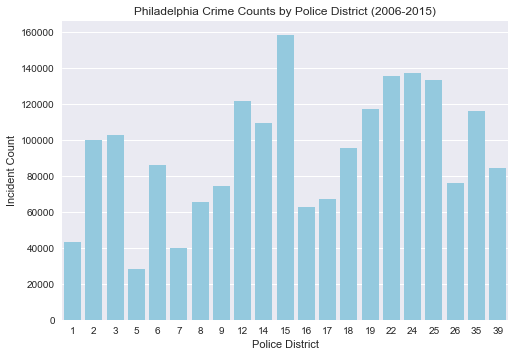

In [49]:
# What parts of the city have the most crime?
dist_bins = np.array([1, 2, 3, 5, 6, 7, 8, 9, 12, 14, 15, 16, 17, 18, 19, 22, 24, 25, 26, 35, 39])
sns.countplot(crime_data['Dc_Dist'], color='skyblue')
plt.title("Philadelphia Crime Counts by Police District (2006-2015)")
plt.xlabel("Police District")
plt.ylabel("Incident Count")
plt.show()

The most common crime types are Theft, Burglary, Vandalism, Fraud, Motor Vehicle Theft, Drug Violations, "Other" Assaults, and "All Other Offenses".

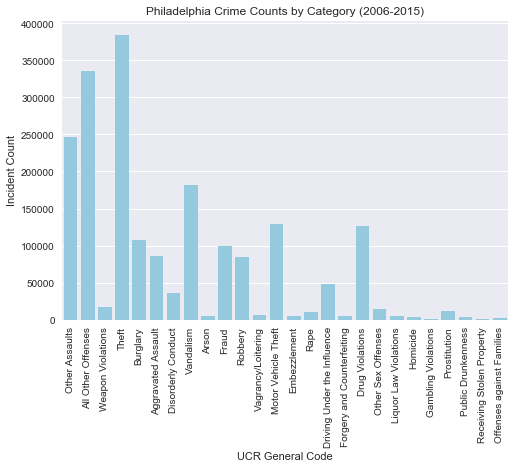

In [51]:
# Which crimes are most frequently committed?
ucr_bins = np.arange(50,2650,100)
sns.countplot(crime_data['UCR_General'], color='skyblue')
plt.title("Philadelphia Crime Counts by Category (2006-2015)")
plt.xlabel("UCR General Code")
plt.ylabel("Incident Count")
plt.xticks(rotation=90)
plt.show()

The number of crimes committed decreased every year from 2006 through 2015.  2008 was the most recent year in which there were over 200K criminal incidents committed in the City of Philadelphia limits.

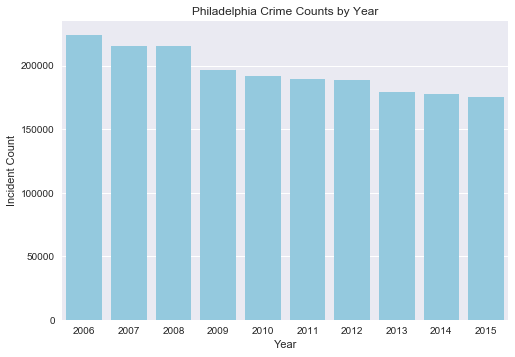

In [52]:
# How has crime changed over time?
sns.countplot(crime_data['Year'], color='skyblue')
plt.title("Philadelphia Crime Counts by Year")
plt.xlabel("Year")
plt.ylabel("Incident Count")
plt.show()

When I analyzed the data set by months, I was not surprised to see fewer crimes in the winter months.  There were well over 150K incidents in each month from March through October.  For time of day, the most incidents took place in the late afternoon and early evening hours (1600 through 2000).  Crime decrased rapidly past midnight and did not rise again until the morning commute hours.  Criminals seem to have enough similarities as the general population in terms of weather preferences, sleeping hours, and working hours.

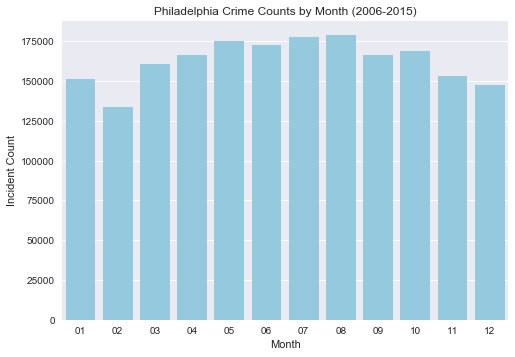

In [53]:
# What times of year do we see the most crimes committed?
sns.countplot(crime_data['Actual_Month'], color='skyblue')
plt.title("Philadelphia Crime Counts by Month (2006-2015)")
plt.xlabel("Month")
plt.ylabel("Incident Count")
plt.show()

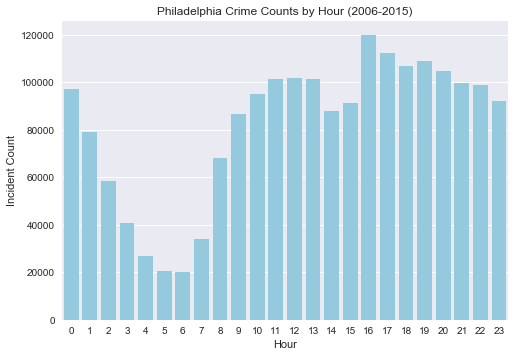

In [54]:
# What times of day do we see the most crimes committed?
sns.countplot(crime_data['Hour'], color='skyblue')
plt.title("Philadelphia Crime Counts by Hour (2006-2015)")
plt.xlabel("Hour")
plt.ylabel("Incident Count")
plt.show()

Finally, I looked at the most frequent crime locations, along with their police districts.  Looking at the top 30 most frequent streets and intersections, there are six located in the 24th district, five in the 3rd district, four in the 6th district, and three in the 9th district.  The 15th district contains only one such location, the 5200 block of Frankford Avenue, which had the third most incidents!

The most frequent and fifth most frequent crime incident locations, on Market Street, are in Center City Philadelphia.  Its police district (6th) was home to over 85K incidents in the 2006 to 2015 time period.  The second most frequent location - the 4600 Block of Roosevelt Boulevard - contains a shopping center.  The third most common place is at the Frankford Transportation Center which is one endpoint for Philadelphia's "El" train.  The fourth most frequent location - the 2300 Block of Cottman Avenue - is near the Roosevelt Mall.  It is no surprise to see more crime in busier places.

In [55]:
## Look at most frequent streets and intersections - where are these located in the city?
location_distinct = crime_data.groupby(['Location_Block', 'Dc_Dist']).size()
location_distinct.sort_values(ascending=False, inplace=True)
print(location_distinct[:30])

Location_Block                          Dc_Dist
1000 BLOCK MARKET ST                    6          3991
4600 BLOCK E ROOSEVELT BLVD             2          3704
5200 BLOCK FRANKFORD AV                 15         3456
2300 BLOCK COTTMAN AV                   2          2605
1300 BLOCK MARKET ST                    6          2353
2800 BLOCK KENSINGTON AV                24         2136
1600 BLOCK S CHRISTOPHER COLUMBUS BLVD  3          2110
2700 BLOCK KENSINGTON AV                24         1975
1500 BLOCK MARKET ST                    9          1916
5900 BLOCK N BROAD ST                   35         1679
0 BLOCK N 52ND ST                       19         1661
0 BLOCK PIA WAY                         12         1653
3200 BLOCK KENSINGTON AV                24         1590
200 BLOCK S 13TH ST                     6          1514
1500 BLOCK JOHN F KENNEDY BLVD          9          1510
2700 BLOCK CASTOR AV                    24         1474
400 BLOCK SOUTH ST                      3          1468


## Bivariate Data Analysis

I started by looking at crime types versus police districts.  Theft is most common crime type with over 7000 in each district.  There were over 20000 thefts in police districts 2, 3, 6, 9, 14, 15, 18, 22, and 24.  There were more than 20000 incidents covered by 'All Other Offenses' - the second most common category, in districts 12, 15, 19, 22, and 24.  The 'Other Assaults' category was the third most common incident type.  There were over 10000 incidents in 13 out of 21 districts.  There were over 15000 crimes of this category in police districts 14, 15, 22, 25, and 35. The 15th district, in the near northeast, saw over 22000 "other" assaults in the 2006 through 2015 period!

There were more than 17000 Vandalism crimes committed in the 15th district.  The top five police districts for vandalism were districts 3, 12, 14, 15, and 22. Drug Violations took place more in the 19th, 22nd, 24th, 25th, and 35th districts.  There were more than 10000 Motor Vehicle Thefts in districts 15, 24, and 25. The 12th district had just below 10000 incidents.  The five most common police districts for bulgarlies were the 12th, 14th, 15th, 22nd, and 24th.

The worst police districts for murder were the 12th, 19th, 22nd, 24th, 25th, 35th, and 39th with over 200 each for the ten year period 2006 through 2015. There were over 150 homicides in the 14th, 15th, and 18th districts.  The worst police districts for rape were the 12th, 14th, 15th, 22nd, 24th, 25th, and 35th, with over 700 each in the ten-year period.  The most robberies occurred in the 15th, 22nd, 24th, 25th, and 35th districts.  Aggravated assaults were most prominent in the 12th, 15th, 22nd, 25th, and 35th districts.

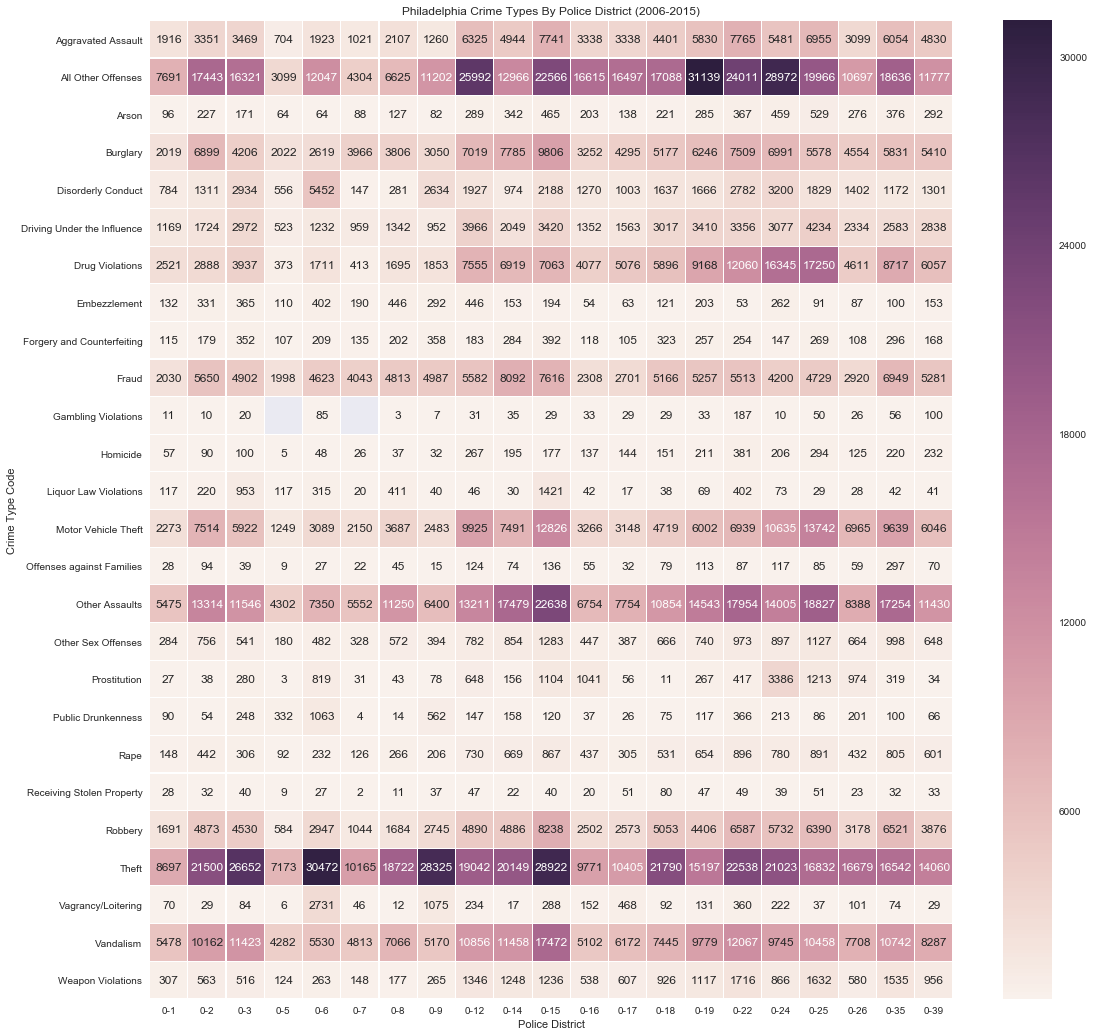

In [58]:
# Crime types by police district
crime_data_type_dist = crime_data.groupby(['UCR_General', 'Dc_Dist']).size()
crime_data_type_dist = crime_data_type_dist.apply(int)
crime_data_type_dist_df = crime_data_type_dist.to_frame()
crime_data_type_dist_pt = pd.pivot_table(crime_data_type_dist_df, index=['UCR_General'], columns=['Dc_Dist'])

# Heatmap representation
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data=crime_data_type_dist_pt, annot=True, linewidths=0.1, fmt='g', ax=ax)
plt.title("Philadelphia Crime Types By Police District (2006-2015)")
plt.xlabel("Police District")
plt.ylabel("Crime Type Code")
plt.show()

Bivariate analysis continued by checking the crime types over time.  I gleamed the following observations in order to determine what factors drove the number of incidents down from 2006 through 2015 in the City of Philadelphia.

The top crime type was not a factor in the declined crime rate.  Thefts remained steady from 2006 through 2014 and finally fell from 37197 in 2014 to 36063 in 2015.  The 'All Other Offenses' category fell steadily from 2006 through 2011 but increased again through 2015.  However, there were over 40000 such incidents in 2006, which helps explain its higher incident count.  The 'All Other Assaults' category saw a slight decline in the ten year period with some fluctuations.

Vandalism, Motor Vehicle Thefts, and Burglaries fell in the 2006 through 2015 period, driving the overall counts downwards.  The number of Vandalism incidents fell by over 8000 between 2006 and 2015.  Motor Vehicle Thefts saw a rapid decline as well - from 20284 in 2006 to 8845 in 2015!  Burglaries fell rapidly between 2013 and 2015 (from 10286 to 7998).  Drug violations also fell steadily from 2020 to 2015. The highest number of drug violations was 15757 in 2008; the lowest number was 7516 in 2015.  The fewer number of Vandalism, Motor Vehicle Thefts, Bulgaries, and Drug Violations helped drive down the crime rate.

Here is the low-down on the worst (but not as common) crime types.  There were more than 300 murders per year from 2006 through 2012.  The murder counts declined by 25% from 2012 to 2013!  The counts stayed below 300 through 2015.  Rapes declined from 2006 through 2011 but increased to their highest level of 1298 in 2015.  Rapes increased by 43% between 2012 and 2013, the same time murders fell the most!  Robberies decreased from 10732 in 2006 down to 6728 in 2015.  Aggravated assaults also fell from 10176 in 2006 down to 7308 in 2014 with slight increase in 2015.

The biggest decrease in crime occurred between 2008 and 2009, driven by decreases in nearly every category.

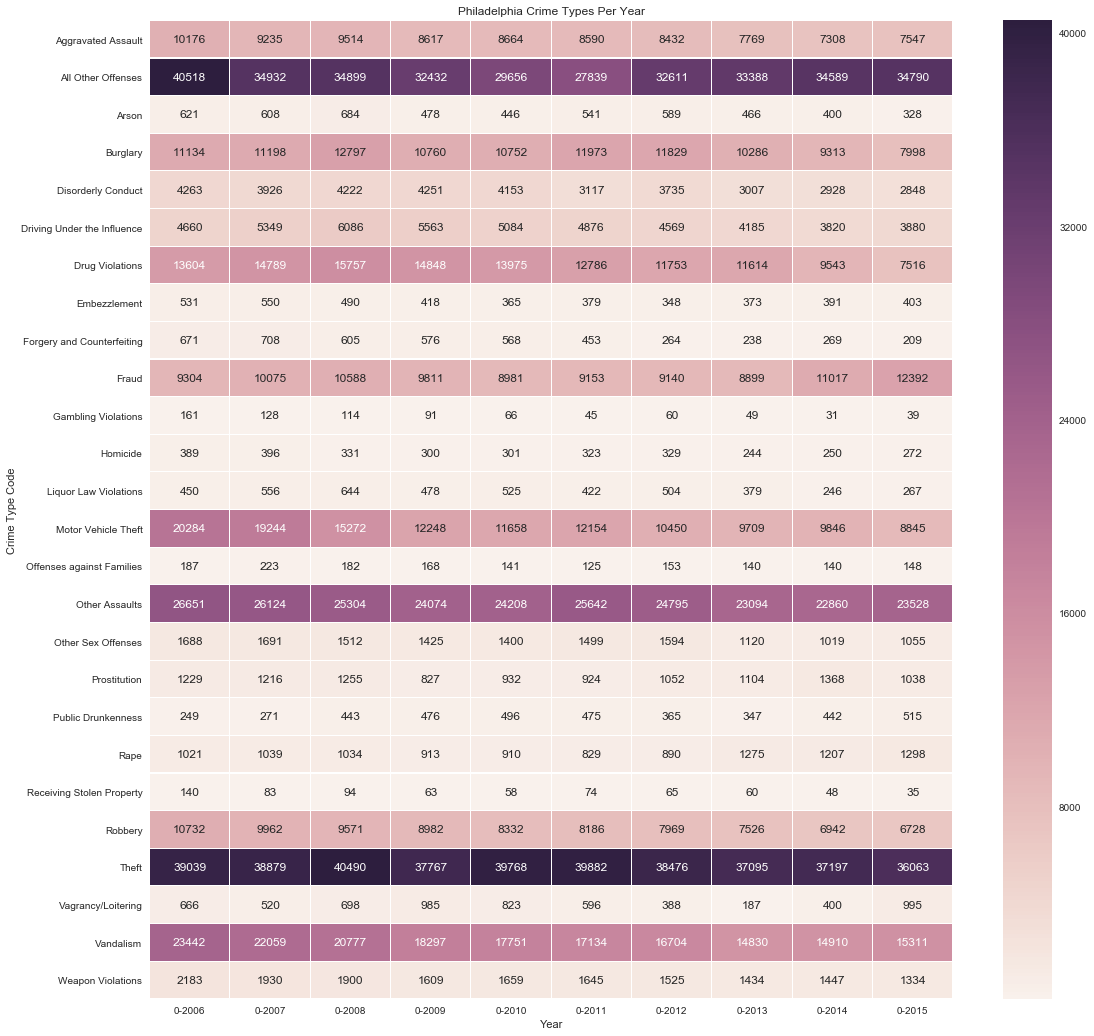

In [61]:
# Crime types by year
crime_data_type_year = crime_data.groupby(['UCR_General', 'Year']).size()
crime_data_type_year = crime_data_type_year.apply(int)
crime_data_type_year_df = crime_data_type_year.to_frame()
crime_data_type_year_pt = pd.pivot_table(crime_data_type_year_df, index=['UCR_General'], columns=['Year'])

# Heatmap representation
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data=crime_data_type_year_pt, annot=True, linewidths=0.1, fmt='g', ax=ax)
plt.title("Philadelphia Crime Types Per Year")
plt.xlabel("Year")
plt.ylabel("Crime Type Code")
plt.show()

Finally, I investigated crime counts by police district per year.  These observations show the decrease in the number of criminal incidents from 2006 through 2015 in all but one police district.  Highlights include the following:

* The 3rd district had its incident count fall nearly every year from 13812 in 2006 to 7883 in 2015, a 43% decline
* The 5th district incident count fell by nearly 50% in the ten year period from 3668 to 1948
* The 8th district saw a decline from 7878 in 2006 down to just 4840 in 2015
* The 12th and 14th districts saw the counts fall by over 3000 each
* The 17th district seen its numbers fall by over 40%
* The 22nd district saw the incidents cut by 33%
* The 25th saw close to 40% decline
* The 35th district saw about a 23% decline in crime incidents
* The 19th district saw an increase in the count

The 19th district is in far west Philadelphia.  The 15th district, which has the most incidents, did not see as large of a decrease as other police districts.

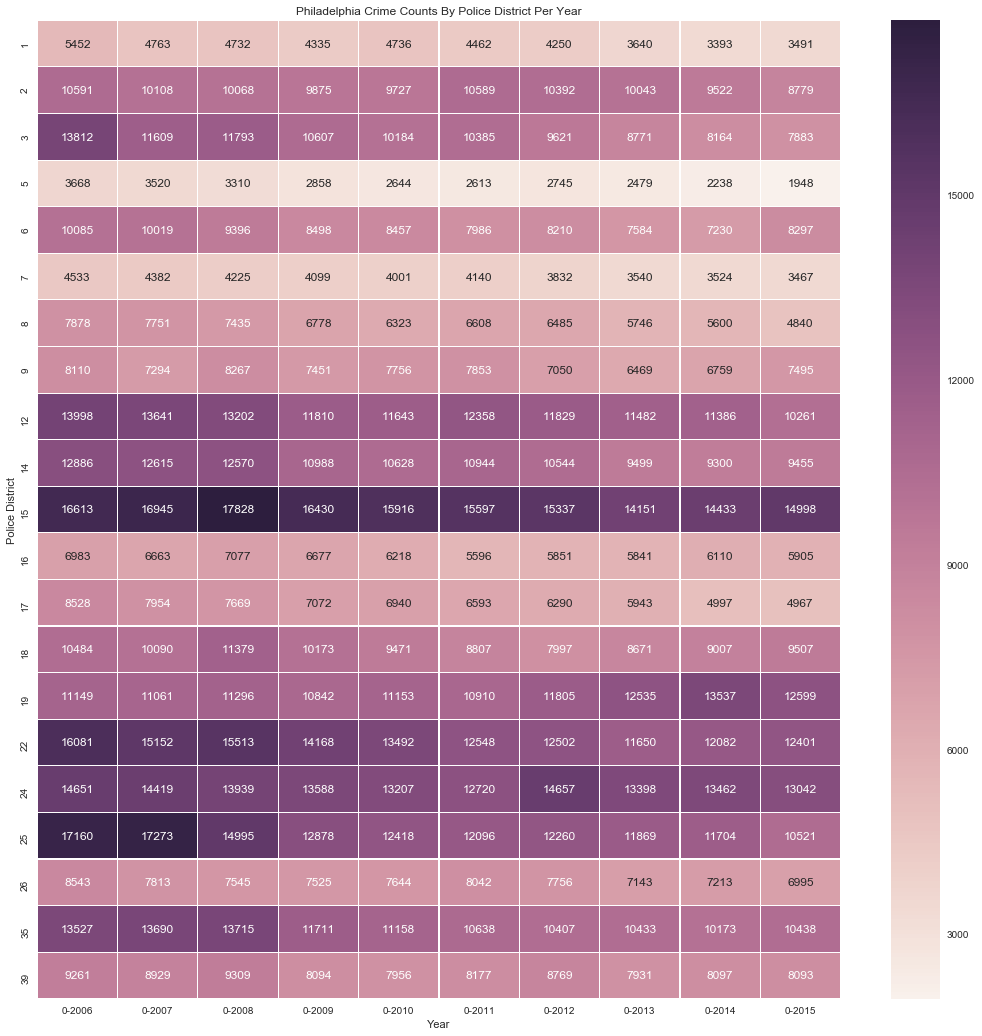

In [62]:
# Police district crime counts by year
crime_data_dist_year = crime_data.groupby(['Dc_Dist', 'Year']).size()
crime_data_dist_year = crime_data_dist_year.apply(int)
crime_data_dist_year_df = crime_data_dist_year.to_frame()
crime_data_dist_year_pt = pd.pivot_table(crime_data_dist_year_df, index=['Dc_Dist'], columns=['Year'])

# Heatmap representation
f, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(data=crime_data_dist_year_pt, annot=True, linewidths=0.1, fmt='g', ax=ax)
plt.title("Philadelphia Crime Counts By Police District Per Year")
plt.xlabel("Year")
plt.ylabel("Police District")
plt.show()

In [ ]:
#### TODO: Multiple variables, summaries, and knit to HTML.